# Logistic Regression

In [54]:
import itertools
import functools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(1234)
%matplotlib inline

### Loss Function aka Binary Cross Entropy Loss

$$
J(\textbf w) = - \sum\limits_{i=1}^{n} \left [ y^{(i)}log\left ( h(\textbf x^{(i)})  \right ) + (1-y^{(i)})log\left ( 1- h(\textbf x^{(i)})  \right ) \right ]
$$

*With L1 Regularization :*

$$
J(\textbf w) = - \sum\limits_{i=1}^{n} \left [ y^{(i)}log\left ( h(\textbf x^{(i)})  \right ) + (1-y^{(i)})log\left ( 1- h(\textbf x^{(i)})  \right ) \right ] + \frac {\lambda } {2} || \textbf w||
$$

*With L2 Regularization :*

$$
J(\textbf w) = - \sum\limits_{i=1}^{n} \left [ y^{(i)}log\left ( h(\textbf x^{(i)})  \right ) + (1-y^{(i)})log\left ( 1- h(\textbf x^{(i)})  \right ) \right ] + \frac {\lambda } {2} || \textbf w||^{2}
$$

where $h(\textbf x^{(i)})$ refers to the non-linear transformation of variable $\textbf x^{(i)}$. Here, it is the *sigmoid function* :

$$
sigmoid(\textbf x) = \frac {1} {1 + e^{-\textbf x}}
$$

$e^{-\textbf x}$ means exponentiate every term in the vector $\textbf x$

### Gradient

$$
\frac{\partial J(\textbf w)}{\partial \textbf w} = \textbf X^{T} (sigmoid(\textbf X \textbf w) - \textbf y) + \lambda \textbf w
$$

## Logistic Regression Class - `LogisticRegression()`

In [56]:
class LogisticRegression():
    def set_weight_vector(self, w):
        self.w = w
    
    def linear_combination(self, X):
        return X @ self.w
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def activation(self, X):
        return self.sigmoid(self.linear_combination(X))
    
    def predict(self, X, threshold=0.5):
        return np.where(self.activation(X) > threshold, 1, 0)
    
    def loss(self, X, y, reg_rate):
        sigmoid_vector = self.activation(X)
        loss_orig = -1 * np.sum(y * np.log(sigmoid_vector) + (1 - y) * np.log(1 - sigmoid_vector))
        reg = reg_rate * np.dot(self.w.T, self.w)
        return loss_orig + reg
    
    def calculate_gradient(self, X, y, reg_rate):
        return X.T @ (self.activation(X) - y) + reg_rate * self.w
    
    def update_weights(self, grad, lr):
        return self.w - grad * lr
    
    def gd(self, X, y, num_epochs, lr, reg_rate):
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        for i in range(num_epochs):
            grad = self.calculate_gradient(X, y, reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y, reg_rate))
            self.w = self.update_weights(grad, lr)
        return self.w



**Helper Functions**

In [65]:
def combinations(x, degree):
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    return functools.reduce(lambda x, y: x * y, items)

def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]

    features = [np.ones(len(x))] # A list of np-arrays with all 1.

    for degree in range(1, degree + 1):
        for item in combinations(x.T, degree):
            features.append(compute_new_features(item))
            
    return np.asarray(features).T

def create_toy_data(factor=3):
    x0 = np.random.normal(size=50).reshape(-1, 2) - factor
    x1 = np.random.normal(size=50).reshape(-1, 2) + factor
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25)-1, np.ones(25)]).astype(np.int)

sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(X_train, labels, lsc, degree=1):
    f = plt.figure(figsize=(8,8))

    x1_min = np.min(x_train[:,1])
    x1_max = np.max(x_train[:,1])
    x2_min = np.min(x_train[:,2])
    x2_max = np.max(x_train[:,2])
    
    x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)) 
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test = lsc.predict(x_test_poly, 0.5)
    
    sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=labels)
    plt.contourf(x1_test, x2_test, y_test.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))
    plt.gca().set_aspect('equal', adjustable='box')
    

def plot_learning_curve(err):
    plt.plot(np.arange(len(err)), err, 'r-')

### Linear Logistic Regression

In [87]:
feature_matrix, label_vector = create_toy_data()
print(feature_matrix.shape, label_vector.shape)

(50, 2) (50,)


C:\Users\Vishvam\AppData\Local\Temp/ipykernel_2500/3221764437.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.concatenate([x0, x1]), np.concatenate([np.zeros(25)-1, np.ones(25)]).astype(np.int)


In [88]:
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)
feature_matrix_bias.shape

(50, 3)

In [89]:
x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector) 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(37, 3) (13, 3) (37,) (13,)


<AxesSubplot:>

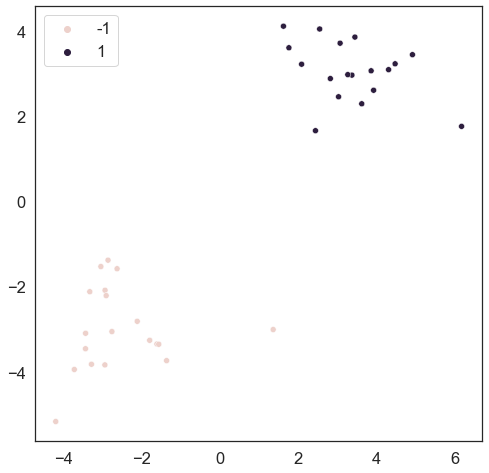

In [90]:
sns.set_style("white")
f = plt.figure(figsize=(8,8))
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)

In [91]:
log_reg = LogisticRegression()
log_reg.gd(x_train, y_train, num_epochs=1000, lr=1e-2, reg_rate=0)

C:\Users\Vishvam\AppData\Local\Temp/ipykernel_2500/1050129834.py:19: RuntimeWarning: divide by zero encountered in log
  loss_orig = -1 * np.sum(y * np.log(sigmoid_vector) + (1 - y) * np.log(1 - sigmoid_vector))
C:\Users\Vishvam\AppData\Local\Temp/ipykernel_2500/1050129834.py:19: RuntimeWarning: invalid value encountered in multiply
  loss_orig = -1 * np.sum(y * np.log(sigmoid_vector) + (1 - y) * np.log(1 - sigmoid_vector))
C:\Users\Vishvam\AppData\Local\Temp/ipykernel_2500/1050129834.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


array([-190.00660993,  485.98660228,  569.03656381])

**The below curve should be smoother. Check for overflows and other errors.**

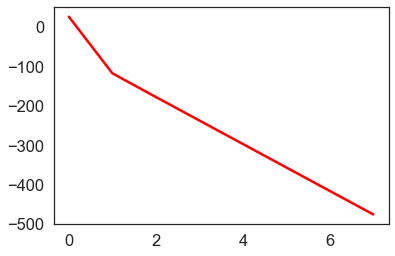

In [92]:
plot_learning_curve(log_reg.err_all)

C:\Users\Vishvam\AppData\Local\Temp/ipykernel_2500/1050129834.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


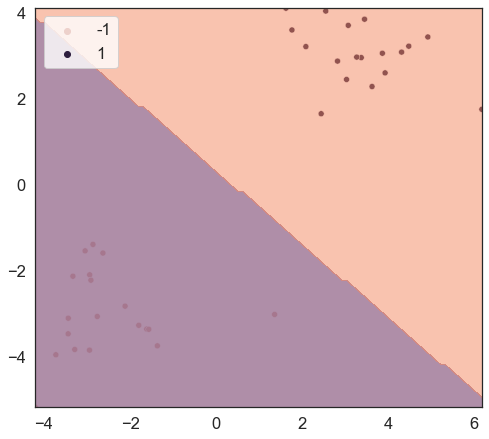

In [93]:
visualize_model(x_train, y_train, log_reg)

In [99]:
y_test_hat = log_reg.predict(x_test)

C:\Users\Vishvam\AppData\Local\Temp/ipykernel_2500/1050129834.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         6
           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         7

    accuracy                           0.54        13
   macro avg       0.33      0.33      0.33        13
weighted avg       0.54      0.54      0.54        13



C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vishvam\anaconda3\lib\site-packages\sklearn\metr

### Non-Linear Logistic Regression

In [101]:
from sklearn.datasets import make_circles
feature_matrix, label_vector = make_circles()

In [102]:
x_poly = polynomial_transform(feature_matrix, degree=2)
x_train, x_test, y_train, y_test = train_test_split(x_poly, label_vector) 
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 6) (25, 6) (75,) (25,)


<AxesSubplot:>

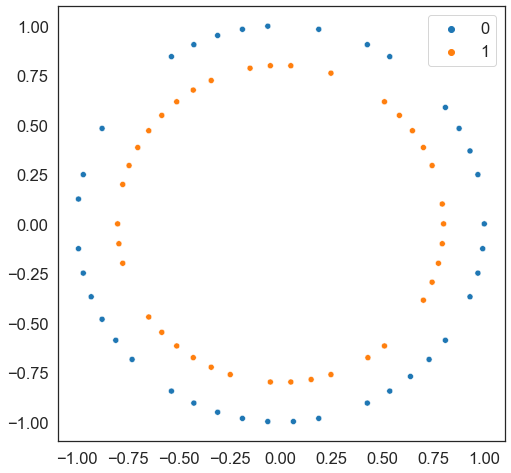

In [103]:
sns.set_style("white")
f = plt.figure(figsize=(8,8))
sns.set_context(context='notebook',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)

In [104]:
log_reg_poly = LogisticRegression()
log_reg_poly.gd(x_train, y_train, num_epochs=10000, lr=1e-2, reg_rate=0)

array([ 20.31667683,  -0.05549775,   0.1150682 , -24.77962226,
        -0.13739925, -24.86263688])

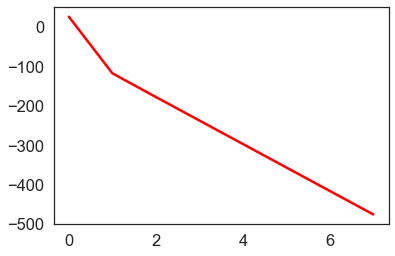

In [105]:
plot_learning_curve(log_reg.err_all)

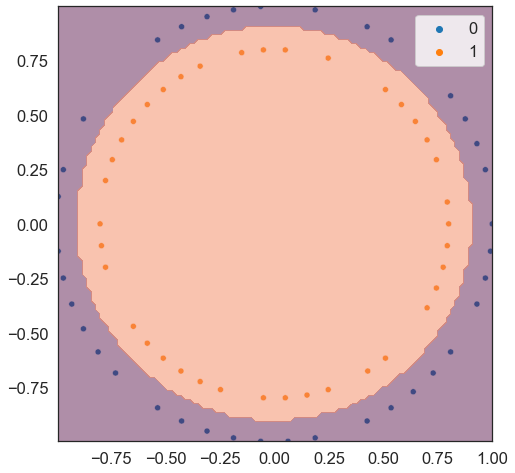

In [106]:
visualize_model(x_train, y_train, log_reg_poly, degree=2)

In [107]:
y_test_hat = log_reg_poly.predict(x_test)
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

